In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D

from tqdm import tqdm_notebook

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import numpy as np

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

from xyz2mol import *

In [2]:
#smiles = [i.strip('\n').split()[0] for i in open('../data/GDB4c.smi', 'r').readlines()]
#smiles = [i.strip('\n').split()[0] for i in open('../data/gdb13.rand1M.smi', 'r').readlines()]

mols = list()
suppl = Chem.SDMolSupplier('../data/qm9/gdb9.sdf')
for mol in tqdm_notebook(suppl):
    if mol:
        if mol.GetNumAtoms()==9:
            atoms = np.array([i.GetAtomicNum() for i in mol.GetAtoms()])
            if np.sum(atoms==6)==7 and np.sum(atoms==8)==2:
                mols.append(mol)

RDKit WARNING: [16:51:12] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [16:51:12] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:12] ERROR: Could not sanitize molecule ending on line 9097
RDKit WARNING: [16:51:12] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [16:51:12] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:12] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:12] ERROR: Could not sanitize molecule ending on line 35785
RDKit ERROR: [16:51:12] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:12] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:12] ERROR: Could not sanitize molecule ending on line 62866
RDKit ERROR: [16:51:12] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:12] Explicit valence for atom 

RDKit ERROR: [16:51:13] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:14] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:14] ERROR: Could not sanitize molecule ending on line 408871
RDKit ERROR: [16:51:14] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:14] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:14] ERROR: Could not sanitize molecule ending on line 408915
RDKit ERROR: [16:51:14] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:14] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:14] ERROR: Could not sanitize molecule ending on line 439217
RDKit ERROR: [16:51:14] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:14] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:14] ERROR: Could not 

RDKit ERROR: [16:51:15] ERROR: Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:51:15] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:15] ERROR: Could not sanitize molecule ending on line 869058
RDKit ERROR: [16:51:15] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:15] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:15] ERROR: Could not sanitize molecule ending on line 869672
RDKit ERROR: [16:51:15] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:16] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:16] ERROR: Could not sanitize molecule ending on line 948794
RDKit ERROR: [16:51:16] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:16] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:16] ERROR: Could not 

RDKit ERROR: [16:51:19] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] ERROR: Could not sanitize molecule ending on line 1452755
RDKit ERROR: [16:51:19] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] ERROR: Could not sanitize molecule ending on line 1452799
RDKit ERROR: [16:51:19] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] ERROR: Could not sanitize molecule ending on line 1453160
RDKit ERROR: [16:51:19] ERROR: Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] ERROR: Could n

RDKit ERROR: [16:51:19] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] ERROR: Could not sanitize molecule ending on line 1502169
RDKit ERROR: [16:51:19] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] ERROR: Could not sanitize molecule ending on line 1502211
RDKit ERROR: [16:51:19] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] ERROR: Could not sanitize molecule ending on line 1503417
RDKit ERROR: [16:51:19] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:19] ERROR: Could n

RDKit ERROR: [16:51:20] ERROR: Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [16:51:20] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:20] ERROR: Could not sanitize molecule ending on line 1651307
RDKit ERROR: [16:51:20] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:20] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:20] ERROR: Could not sanitize molecule ending on line 1651351
RDKit ERROR: [16:51:20] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:20] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [16:51:20] ERROR: Could not sanitize molecule ending on line 1651487
RDKit ERROR: [16:51:20] ERROR: Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [16:51:20] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [16:51:20] ERROR: Could n

RDKit ERROR: [16:51:22] ERROR: Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:22] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:22] ERROR: Could not sanitize molecule ending on line 1917509
RDKit ERROR: [16:51:22] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:22] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:22] ERROR: Could not sanitize molecule ending on line 1921029
RDKit ERROR: [16:51:22] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:22] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:22] ERROR: Could not sanitize molecule ending on line 1940049
RDKit ERROR: [16:51:22] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:22] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:22] ERROR: Could n

RDKit ERROR: [16:51:24] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:24] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:24] ERROR: Could not sanitize molecule ending on line 2234406
RDKit ERROR: [16:51:24] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:24] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:24] ERROR: Could not sanitize molecule ending on line 2234727
RDKit ERROR: [16:51:24] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:24] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:24] ERROR: Could not sanitize molecule ending on line 2276115
RDKit ERROR: [16:51:24] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:24] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:24] ERROR: Could n

RDKit ERROR: [16:51:26] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:51:27] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:27] ERROR: Could not sanitize molecule ending on line 2658934
RDKit ERROR: [16:51:27] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:27] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:27] ERROR: Could not sanitize molecule ending on line 2659036
RDKit ERROR: [16:51:27] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:27] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:27] ERROR: Could not sanitize molecule ending on line 2659133
RDKit ERROR: [16:51:27] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:27] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:27] ERROR: Could n

RDKit ERROR: [16:51:28] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] ERROR: Could not sanitize molecule ending on line 2911099
RDKit ERROR: [16:51:29] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] ERROR: Could not sanitize molecule ending on line 2911218
RDKit ERROR: [16:51:29] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] ERROR: Could not sanitize molecule ending on line 2912725
RDKit ERROR: [16:51:29] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] ERROR: Could n

RDKit ERROR: [16:51:29] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] ERROR: Could not sanitize molecule ending on line 2948086
RDKit ERROR: [16:51:29] ERROR: Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] ERROR: Could not sanitize molecule ending on line 2948371
RDKit ERROR: [16:51:29] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] ERROR: Could not sanitize molecule ending on line 2948418
RDKit ERROR: [16:51:29] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:29] ERROR: Could n

RDKit ERROR: [16:51:31] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:31] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:51:31] ERROR: Could not sanitize molecule ending on line 3297837
RDKit ERROR: [16:51:31] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:51:31] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:51:31] ERROR: Could not sanitize molecule ending on line 3297878
RDKit ERROR: [16:51:31] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:51:31] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:51:31] ERROR: Could not sanitize molecule ending on line 3298417
RDKit ERROR: [16:51:31] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:51:31] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:51:31] ERROR: Could n

RDKit ERROR: [16:51:32] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:33] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:33] ERROR: Could not sanitize molecule ending on line 3530675
RDKit ERROR: [16:51:33] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:33] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:33] ERROR: Could not sanitize molecule ending on line 3530764
RDKit ERROR: [16:51:33] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:33] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:33] ERROR: Could not sanitize molecule ending on line 3532822
RDKit ERROR: [16:51:33] ERROR: Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:33] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:33] ERROR: Could n

RDKit ERROR: [16:51:35] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:35] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:35] ERROR: Could not sanitize molecule ending on line 3820516
RDKit ERROR: [16:51:35] ERROR: Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:35] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:35] ERROR: Could not sanitize molecule ending on line 3820711
RDKit ERROR: [16:51:35] ERROR: Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:35] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:35] ERROR: Could not sanitize molecule ending on line 3820802
RDKit ERROR: [16:51:35] ERROR: Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:35] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:35] ERROR: Could n

RDKit ERROR: [16:51:38] ERROR: Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:51:39] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:39] ERROR: Could not sanitize molecule ending on line 4532211
RDKit ERROR: [16:51:39] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:39] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:39] ERROR: Could not sanitize molecule ending on line 4532424
RDKit ERROR: [16:51:39] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:39] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:39] ERROR: Could not sanitize molecule ending on line 4535302
RDKit ERROR: [16:51:39] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:39] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:39] ERROR: Could n

RDKit ERROR: [16:51:39] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [16:51:40] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:40] ERROR: Could not sanitize molecule ending on line 4715953
RDKit ERROR: [16:51:40] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:40] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:40] ERROR: Could not sanitize molecule ending on line 4716113
RDKit ERROR: [16:51:40] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [16:51:40] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:40] ERROR: Could not sanitize molecule ending on line 4733108
RDKit ERROR: [16:51:40] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:51:40] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:51:40] ERROR: Could n

RDKit ERROR: [16:51:43] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:51:43] ERROR: Could not sanitize molecule ending on line 5188493
RDKit ERROR: [16:51:43] ERROR: Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:51:43] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:51:43] ERROR: Could not sanitize molecule ending on line 5188852
RDKit ERROR: [16:51:43] ERROR: Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:51:43] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:43] ERROR: Could not sanitize molecule ending on line 5291825
RDKit ERROR: [16:51:43] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:43] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:43] ERROR: Could not sanitize molecule ending on line 5292089
RDKit ERROR: [16:51:43] ERROR: Explicit valence f

RDKit ERROR: [16:51:45] ERROR: Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:46] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:46] ERROR: Could not sanitize molecule ending on line 5716869
RDKit ERROR: [16:51:46] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:51:46] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:46] ERROR: Could not sanitize molecule ending on line 5729263
RDKit ERROR: [16:51:46] ERROR: Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:46] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:51:46] ERROR: Could not sanitize molecule ending on line 5729540
RDKit ERROR: [16:51:46] ERROR: Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:51:46] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [16:51:46] ERROR: Could n

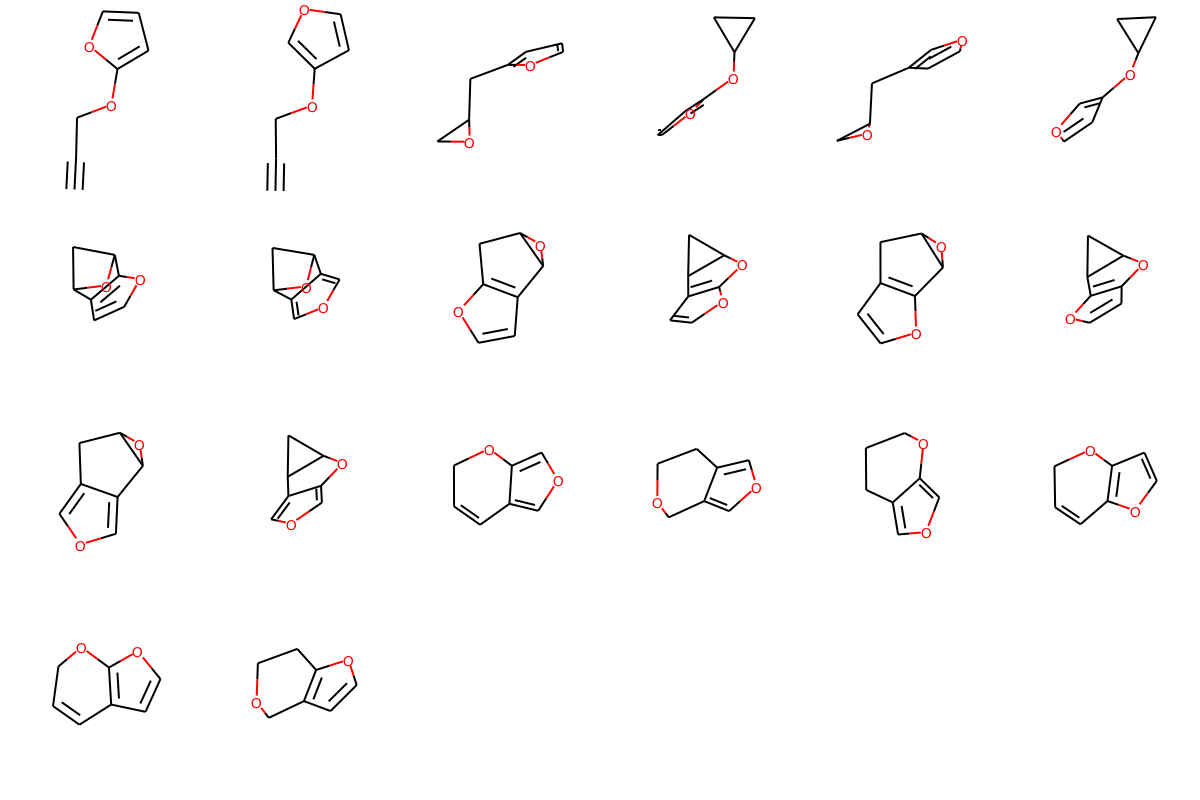

In [146]:
Draw.MolsToGridImage(mols[:20], molsPerRow=6)

In [40]:
def getEDM(mol):
    #get 3d coords
    m3 = Chem.AddHs(mol)
    embed = AllChem.EmbedMolecule(m3)
    if embed+1:  
        m3 = Chem.RemoveHs(m3)
        conformer = m3.GetConformer(0)
        positions = conformer.GetPositions()
        return positions
    else:
        return None

In [41]:
edms = list()
atomidx = list()
for m in tqdm_notebook(mols):
    points = getEDM(m)
    if points is None:
        None
    else:
        edm = pdist(points)
        edms.append(edm)
        
        atoms = np.array([i.GetAtomicNum() for i in m.GetAtoms()])
        atomidx.append(atoms)

KeyboardInterrupt: 

# Exploratory GMM fitting on data, with PCA to reduce dimensionality.

Are EDMs noisy? Apparently since they can be reduced so much. Must be because they are triangular - Maybe it's best to use the reduced form returned by pdist after all. 

Anyways, this uses code from https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html


First, reshape by flattening the matrices into (n,1) of flat features because sklearn likes that:

In [42]:
edms = np.array(edms)
#edms_flat = edms.reshape(edms.shape[0], edms.shape[1]*edms.shape[1])
#print(edms_flat.shape)

We can reduce the number of dimensions substantially using a PCA, and then just turn it back into full number later using the inverse_transform method:

In [43]:
##reduce noise using pca?
pca = PCA(0.99, whiten=True) ##keep 99 percent of variance. 
data = pca.fit_transform(edms)

In [44]:

print('Went from:', edms.shape, 'dimensions to:', data.shape)

Went from: (324, 36) dimensions to: (324, 21)


In [45]:
##Stacking EDMs onto atom identities:
number = 200
data = np.hstack([data[:200], np.array(atomidx[:200])])

# GMM:

How many components does the GMM need? Low AIC is better. 
The below plots AIC vs dimensions, and shows we need a lot of dims for just 13 atoms... it might become infeasible for drug like molecules but this is just a baseline.

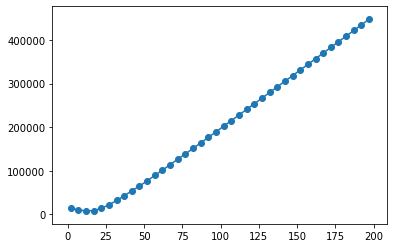

In [46]:
n_components = np.arange(2, 200, 5)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data[:1000]).bic(data) for model in models]
plt.plot(n_components, aics);
plt.scatter(n_components, aics);

In [47]:
gmm = GaussianMixture(50, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


[7.0546 7.0446 6.6753 5.9981 6.5873 6.0006 6.739  6.0015 5.9043]


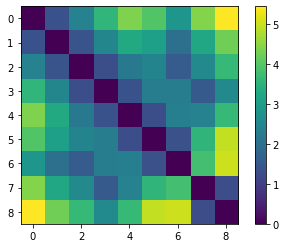

In [198]:
data_new = np.array(gmm.sample(100)[0])[11]
atomidentities = data_new[-9:]
print(np.around(atomidentities, 4))
data_new = data_new[:-9]
new_sample =squareform(pca.inverse_transform([data_new])[0])
new_sample = new_sample-np.min(new_sample)

plt.imshow(new_sample)
plt.colorbar()

# Turn EDM into real coordinates

(we will have to assume these are all carbons for now:

In [199]:
def to_M_matrix(D):
    D1j = np.tile(D[0, :], len(D)).reshape(D.shape)
    Di1 = D1j.T
    return .5 * (-D + D1j + Di1)

def setPositions(mol_in, coords):
    conformer = mol_in.GetConformer(0)
    for i in range(mol_in.GetNumAtoms()):
        x,y,z = coords[i]
        conformer.SetAtomPosition(i,Point3D(x,y,z))
    return mol_in

D = new_sample**2
M = to_M_matrix(D)
S, U = np.linalg.eigh(M)

coord = np.matmul(U, np.diag(np.sqrt(np.abs(S))))
X = coord[:, -3:]


It's difficult to ensure that you only have 6 carbons and 2 oxygens. But we know _a priori_ that the GMM is only drawing samples from the distribution generated by the input. So each EDM must be legitimate! The real novelty must be in the postprocessing step. Ignore the atom identity, and just generate EDMs. Then, turn an EDM into a graph using bonding rules. This will be the hardest bit.  

In [200]:
xyzfile = open('xyzfile.xyz', 'w')
xyzfile.write('9\n')
xyzfile.write('charge=0=\n')
for j in range(9):
    if atomidentities[j]<7:
        atomstring = 'C'
    else:
        atomstring = 'O'
        
    xyzfile.write(atomstring+'\t'+str(X[j][0])+'\t'+str(X[j][1])+'\t'+str(X[j][2])+'\n')

xyzfile.close()


In [201]:
atomicNumList, charge, xyz_coordinates = read_xyz_file('xyzfile.xyz')
am, mol =xyz2AC(atomicNumList,xyz_coordinates)

In [202]:
eMol = Chem.EditableMol(mol)

In [203]:
bonds = np.triu(am)
for j, k in zip(np.where(bonds)[0], np.where(bonds)[1]):
    print(j,k)
    try:
        eMol.AddBond(int(j),int(k))
    except:
        None


0 1
1 2
2 3
2 6
3 4
3 7
4 5
5 6
7 8


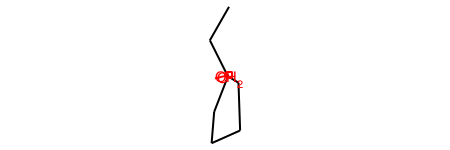

In [204]:
mol = eMol.GetMol()

Chem.rdmolfiles.MolToPDBFile(mol, 'tempmol.pdb', flavor=0)
mol

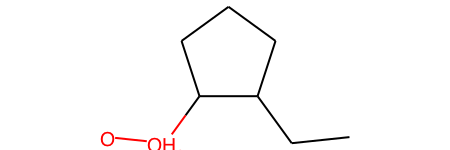

In [205]:
Chem.rdDepictor.Compute2DCoords(mol)

mol